In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!pip install scikit-learn


In [ ]:
!pip install nltk gensim spacy pandas numpy sentence-transformers matplotlib seaborn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [ ]:
import nltk
import spacy
import string
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


In [ ]:
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load Spacy model
nlp = spacy.load('en_core_web_sm')

# Define legal vocabularies (for demonstration purposes)
LEGAL_VOCABULARIES = {"plaintiff", "defendant", "court", "judge", "trial", "evidence", "law"}

def preprocess_text(file_path):
    with open(file_path, 'r') as file:
        text = file.read()

    # Define the structure and sentence segmentation
    sentences = sent_tokenize(text)

    # Initialize tools
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    processed_sentences = []
    for sentence in sentences:
        # Tokenize
        words = word_tokenize(sentence)
        # Remove stop words and punctuation, and lower case
        words = [word.lower() for word in words if word.lower() not in stop_words and word not in string.punctuation]
        # Stemming and lemmatization
        words = [stemmer.stem(word) for word in words]
        words = [lemmatizer.lemmatize(word) for word in words]
        processed_sentences.append((sentence, words))

    return processed_sentences

def get_bert_embeddings(sentences):
    model = SentenceTransformer('bert-base-nli-mean-tokens')
    embeddings = model.encode(sentences, convert_to_tensor=True)
    return embeddings

def cluster_sentences_bert(embeddings, num_clusters,sentences):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(embeddings)
    clusters = kmeans.labels_.tolist()

    clustered_sentences = {}
    for i, cluster in enumerate(clusters):
        if cluster not in clustered_sentences:
            clustered_sentences[cluster] = []
        clustered_sentences[cluster].append(sentences[i])

    return clustered_sentences, clusters

def score_sentences_bert(clustered_sentences, embeddings):
    scores = {}
    for cluster, sentences in clustered_sentences.items():
        cluster_scores = []
        cluster_embedding = np.mean([embeddings[sentences.index(s)] for s in sentences], axis=0)
        for i, sentence in enumerate(sentences):
            words = word_tokenize(sentence.lower())
            score = sum(1 for word in words if word in LEGAL_VOCABULARIES)  # Example feature: count of legal vocabularies
            # Combine with BERT embeddings (cosine similarity with cluster centroid)
            cosine_sim = np.dot(embeddings[sentences.index(sentence)], cluster_embedding) / (np.linalg.norm(embeddings[sentences.index(sentence)]) * np.linalg.norm(cluster_embedding))
            score += cosine_sim  # Combine scores (this is a simple combination, you can use more sophisticated methods)
            cluster_scores.append(score)
        # Normalize scores within the cluster
        normalized_scores = normalize([cluster_scores])[0]
        scores[cluster] = list(zip(sentences, normalized_scores))

    return scores

def generate_summary(scored_sentences, compression_rate=0.3):
    summary = []
    for cluster, sentences in scored_sentences.items():
        # Sort sentences by score in descending order
        sentences = sorted(sentences, key=lambda x: x[1], reverse=True)
        num_sentences_to_include = max(1, int(len(sentences) * compression_rate))
        summary.extend([sentence for sentence, score in sentences[:num_sentences_to_include]])

    return " ".join(summary)

def visualize_clusters(embeddings, clusters):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=clusters, palette="deep", legend="full")
    plt.title("Cluster Visualization with PCA")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.show()

# Full workflow with BERT embeddings and visualization
def summarize_legal_document_bert(file_path, num_clusters=5, compression_rate=0.3):
    processed_sentences = preprocess_text(file_path)
    sentences = [sentence for sentence, _ in processed_sentences]
    embeddings = get_bert_embeddings(sentences)
    clustered_sentences, clusters = cluster_sentences_bert(embeddings, num_clusters,sentences)
    scored_sentences = score_sentences_bert(clustered_sentences, embeddings)
    summary = generate_summary(scored_sentences, compression_rate)

    visualize_clusters(embeddings, clusters)

    return summary

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


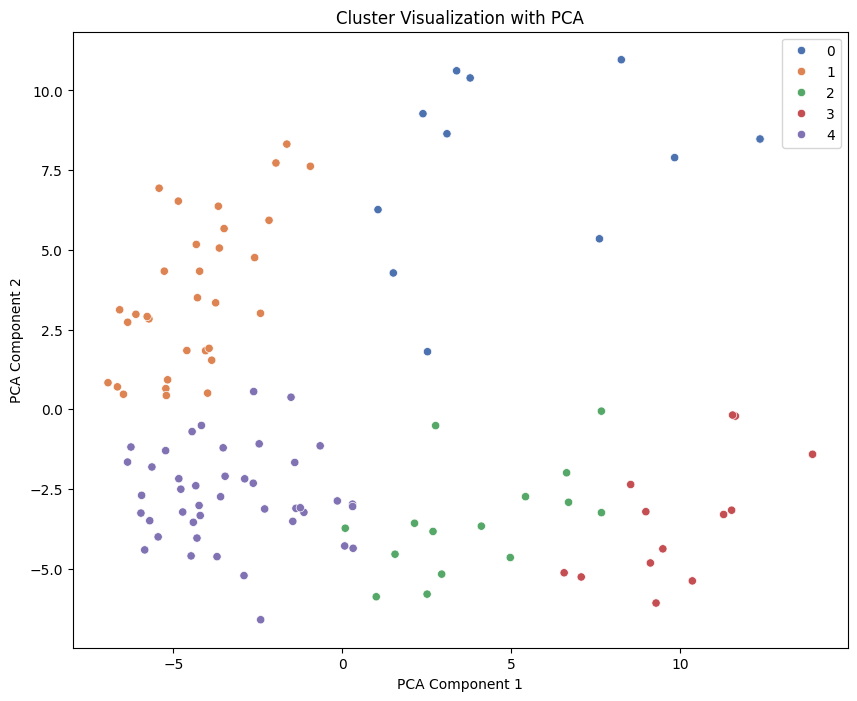

Summary: . . 46/59). 133. Appeal by special leave from the judgment and order dated March 25, 1957, of the former Bombay High Court in Appeal No. The Judgment of the Court was delivered by DAS GUPTA J.
M/s. It is equally undisputed that the persons to whom M/s. In the Exports (Control) Order, 1954, the word must be taken to have the same meaning as in the Act. In this view the learned Judge dismissed the application under article 226. No. No. The Sales Tax Officer as also the High Court of Bombay has held that the " person to whom he has sold the goods " in section 10(b) means " a registered dealer to whom he has sold the goods ". The law is now well settled that if the property in the goods passes to the buyer after they have for the purpose of export to a foreign country crossed the customs frontier the sale has taken place "in course of the export" out of the territory of India. It is true that in the United Motor '8 Case (1) and in other cases it has been held by this Court that th

In [ ]:
file_path = '/content/drive/MyDrive/to be delete/judgment/1329.txt'
summary_bert = summarize_legal_document_bert(file_path)
print("Summary:", summary_bert)

# training with JSON

In [ ]:
pip install wandb

In [ ]:
pip install datasets

In [ ]:
import requests
import json
import pandas as pd
from datasets import Dataset

# Step 1: Download the JSON file
url = "https://storage.googleapis.com/indianlegalbert/OPEN_SOURCED_FILES/Rhetorical_Role_Benchmark/Data/train.json"
response = requests.get(url)
json_data = response.json()


In [ ]:
print(json.dumps(json_data[0], indent=4))

In [ ]:
json_data

In [ ]:
def json_to_dataframe(json_data):
    data = []
    for document in json_data:
        doc_id = document.get("id")
        for annotation in document.get("annotations", []):
            for result in annotation.get("result", []):
                segment = {
                    'doc_id': doc_id,
                    'text': result['value'].get('text'),
                    'label': result['value'].get('labels', [None])[0]  # Get the first label if available
                }
                data.append(segment)
    return pd.DataFrame(data)

In [ ]:
# Convert JSON to DataFrame
df = json_to_dataframe(json_data)
print(df.head(100))

    doc_id                                               text     label
0     1735        IN THE HIGH COURT OF KARNATAKA,\n       ...  PREAMBLE
1     1735  \n\n      BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...  PREAMBLE
2     1735  This Criminal Appeal is filed under Section 37...  PREAMBLE
3     1735  \n\n       This appeal coming on for hearing t...  PREAMBLE
4     1735  \n       Heard the learned Counsel for the app...      NONE
..     ...                                                ...       ...
95    4183                                          \nJUSTICE  PREAMBLE
96    4183  .\n\n         THIS I.T.A. COMING ON FOR HEARIN...  PREAMBLE
97    4183          \nS. SUJATHA J. DELIVERED THE FOLLOWING:-  PREAMBLE
98    4183       \n\n                                JUDGMENT  PREAMBLE
99    4183  \nMr. E.I.Sanmathi Adv. for Appellants- Revenu...      NONE

[100 rows x 3 columns]


In [ ]:
df

,doc_id,text,label
0,1735,"IN THE HIGH COURT OF KARNATAKA,\n ...",PREAMBLE
1,1735,\n\n BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...,PREAMBLE
2,1735,This Criminal Appeal is filed under Section 37...,PREAMBLE
3,1735,\n\n This appeal coming on for hearing t...,PREAMBLE
4,1735,\n Heard the learned Counsel for the app...,NONE
...,...,...,...
28981,4090,\n So Section 132 of the Evidence Act sufficie...,RATIO
28982,4090,"\n For the reasons aforesaid, the appeal is al...",RPC
28983,4090,"The judgment and order dated April 27, 1987 pa...",RPC
28984,4090,\n R.S.S.,NONE


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
df['label'] = label_encoder.fit_transform(df['label'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)
# Convert DataFrame to Hugging Face Dataset again
dataset = Dataset.from_pandas(df)

{'ANALYSIS': 0, 'ARG_PETITIONER': 1, 'ARG_RESPONDENT': 2, 'FAC': 3, 'ISSUE': 4, 'NONE': 5, 'PREAMBLE': 6, 'PRE_NOT_RELIED': 7, 'PRE_RELIED': 8, 'RATIO': 9, 'RLC': 10, 'RPC': 11, 'STA': 12}


In [ ]:
dataset.features

{'doc_id': Value(dtype='int64', id=None),
 'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

Trying smaller model and dataset

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from datasets import load_dataset, Dataset
import torch
import pandas as pd

"""
# Step 1: Load a pre-trained model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

''' # Step 2: Load and process a smaller dataset
# Assume 'df' is your DataFrame
sample_df = df.sample(frac=0.05)  # Use 5% of the data
dataset = Dataset.from_pandas(sample_df)'''

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Step 3: Setup Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    save_total_limit=1,
    save_steps=1000,
    report_to="wandb"
    logging_dir="./logs",
)

# Step 4: Initialize Trainer and Train
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(df['label'])))

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
)

trainer.train()
"""

'\n# Step 1: Load a pre-trained model and tokenizer\nmodel_name = "distilbert-base-uncased"\ntokenizer = AutoTokenizer.from_pretrained(model_name)\n\n\'\'\' # Step 2: Load and process a smaller dataset\n# Assume \'df\' is your DataFrame\nsample_df = df.sample(frac=0.05)  # Use 5% of the data\ndataset = Dataset.from_pandas(sample_df)\'\'\'\n\ndef tokenize_function(example):\n    return tokenizer(example["text"], padding="max_length", truncation=True)\n\ntokenized_dataset = dataset.map(tokenize_function, batched=True)\n\n# Step 3: Setup Training Arguments\ntraining_args = TrainingArguments(\n    output_dir="./results",\n    num_train_epochs=3,\n    per_device_train_batch_size=8,\n    gradient_accumulation_steps=4,\n    save_total_limit=1,\n    save_steps=1000,\n    report_to="wandb"\n    logging_dir="./logs",\n)\n\n# Step 4: Initialize Trainer and Train\nmodel = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(df[\'label\'])))\n\ntrainer = Trainer(\n    m

In [ ]:
# Load your DataFrame 'df' here
# df = pd.read_csv('path_to_your_data.csv') # Adjust as needed
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from datasets import load_dataset, Dataset
import torch
import pandas as pd
# Step 1: Load a pre-trained model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Step 4: Initialize Trainer and Train
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(df['label'])))
# Step 2: Convert DataFrame to Hugging Face Dataset and encode labels
def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Convert DataFrame to Dataset
dataset = Dataset.from_pandas(df)

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/28986 [00:00<?, ? examples/s]

In [ ]:
from datasets import DatasetDict
# Split the dataset into train, test, and eval sets
# Adjust the splits according to your needs
split_dataset = tokenized_dataset.train_test_split(test_size=0.2)
train_test_dataset = split_dataset['test'].train_test_split(test_size=0.5)

datasets = DatasetDict({
    'train': split_dataset['train'],
    'test': train_test_dataset['test'],
    'eval': train_test_dataset['train']
})

In [ ]:
#To see the train set
import pandas as pd

# Convert the Hugging Face Dataset to a Pandas DataFrame
train_df = datasets['train'].to_pandas()

# Display the DataFrame
print(train_df)

       doc_id                                               text  label  \
0        1756  On the other hand, the judgment of Delhi High ...      8   
1        4161  Such an assault may attract the relevant provi...      2   
2        1718                                         Properties      3   
3        4260  The only point that has to be decided in dispo...      9   
4        4231  \n\n                 PRESENT\n\n     THE HON'B...      6   
...       ...                                                ...    ...   
23183    4155  The price of Rs.\n400 per share was so out of ...      0   
23184    4191  The word `other manufacture' has to be read in...      0   
23185    4127  (v) There were abrasion on the chin 5 cm in le...      3   
23186    1711  It would be unusual to provide an appeal from ...      0   
23187    1746  After 2 to 3 mothers the respondent returned t...      0   

                                               input_ids  \
0      [101, 2006, 1996, 2060, 2192, 10

In [ ]:
train_test_dataset

DatasetDict({
    train: Dataset({
        features: ['doc_id', 'text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2899
    })
    test: Dataset({
        features: ['doc_id', 'text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2899
    })
})

In [ ]:
# Step 3: Setup Training Arguments
training_args = TrainingArguments(
    output_dir="./resultsdistilledbert1",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    save_total_limit=1,
    save_steps=1000,
    logging_dir="./logs",
    report_to="wandb"  # Ensure W&B is properly set up, or remove this line
)

# Step 4: Initialize Trainer and Train
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(df['label'])))

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets['train'],
    eval_dataset=datasets['eval']
)

trainer.train()


NameError: name 'df' is not defined

In [ ]:
# Save model and tokenizer
model.save_pretrained("/content/drive/MyDrive/to be delete/my model")
tokenizer.save_pretrained("/content/drive/MyDrive/to be delete/my model")

('/content/drive/MyDrive/to be delete/my model/tokenizer_config.json',
 '/content/drive/MyDrive/to be delete/my model/special_tokens_map.json',
 '/content/drive/MyDrive/to be delete/my model/vocab.txt',
 '/content/drive/MyDrive/to be delete/my model/added_tokens.json',
 '/content/drive/MyDrive/to be delete/my model/tokenizer.json')

# Precision, Recall, F1 score, Accuracy (Evaluating Model)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import Trainer

# Define a compute_metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# If the model is already trained, just initialize the Trainer with the same model
trainer = Trainer(
    model=model,  # Use your already trained model
    #args=training_args,
    eval_dataset=datasets['eval'],  # Use your evaluation dataset
    compute_metrics=compute_metrics  # Include the metrics function
)

# Evaluate the model
results = trainer.evaluate()

# Print the evaluation results
print(results)



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: engineersaloni159 (salonijnu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 2.6378674507141113, 'eval_model_preparation_time': 0.0013, 'eval_accuracy': 0.046912728527078305, 'eval_precision': 0.007919913642667155, 'eval_recall': 0.046912728527078305, 'eval_f1': 0.004799077797168514, 'eval_runtime': 40.5507, 'eval_samples_per_second': 71.491, 'eval_steps_per_second': 8.952}


In [ ]:
model

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import Trainer

# Define a compute_metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Initialize the Trainer with the already trained model
trainer = Trainer(
    model=model,  # Use your already trained model
    args=training_args,
    eval_dataset=datasets['test'],  # Use your test dataset
    compute_metrics=compute_metrics  # Include the metrics function
)

# Evaluate the model on the test dataset
results = trainer.evaluate()

# Print the evaluation results
print("Test Set Evaluation Results:")
print(results)


Test Set Evaluation Results:
{'eval_loss': 0.9759261608123779, 'eval_model_preparation_time': 0.0015, 'eval_accuracy': 0.6826491893756468, 'eval_precision': 0.6777440900101154, 'eval_recall': 0.6826491893756468, 'eval_f1': 0.6732117581112917, 'eval_runtime': 49.6047, 'eval_samples_per_second': 58.442, 'eval_steps_per_second': 7.318}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Make predictions
predictions = trainer.predict(tokenized_dataset)
predicted_labels = predictions.predictions.argmax(-1)

# Print predicted labels
print(predicted_labels)

[3 6 6 ... 0 6 0]


# save this model on huggingface

In [ ]:
pip install huggingface_hub


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

In [ ]:
from huggingface_hub import HfApi

# Define repository name and create repo on the hub
repo_name = "In_legal_distillbert"  # Choose a unique name
HfApi().create_repo(repo_name)

# Upload the model
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/engineersaloni159/In_legal_distillbert/commit/ebc4c10b7b1040053b267cba98b9a42ee84dcb11', commit_message='Upload tokenizer', commit_description='', oid='ebc4c10b7b1040053b267cba98b9a42ee84dcb11', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
model.save_pretrained(repo_name, push_to_hub=True)
tokenizer.save_pretrained(repo_name, push_to_hub=True)


('In_legal_distillbert/tokenizer_config.json',
 'In_legal_distillbert/special_tokens_map.json',
 'In_legal_distillbert/vocab.txt',
 'In_legal_distillbert/added_tokens.json',
 'In_legal_distillbert/tokenizer.json')

# Manually Evaluation of model

In [ ]:
pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("engineersaloni159/In_legal_distillbert")
model = AutoModelForSequenceClassification.from_pretrained("engineersaloni159/legal_distillbert")


tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Ensure model is in evaluation mode
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
#run this cell if model is directly called from  huggingface
from sklearn.preprocessing import LabelEncoder

# Assuming you already have this
label_encoder = LabelEncoder()

# Fit and transform the labels
df['label'] = label_encoder.fit_transform(df['label'])

# Print the mapping of labels to numbers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12}


In [ ]:
# Assuming label_encoder is the one you used for encoding labels earlier

# Example sentence
sentence = "\n So far as the present case is concerned it has already been pointed out above, that the circumstances of the case and the course of dealings between the parties show that there was an implied agreement or understanding between the parties that the money would be sent to the assessee by cheques posted from British India."
# Tokenize the sentence
inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)

# Make predictions
with torch.no_grad():
    outputs = model(**inputs)

# The predictions are in the form of logits, you can convert them to probabilities
logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1)

# Convert the predicted class number to the original label
predicted_label = label_encoder.inverse_transform(predicted_class.cpu().numpy())[0]

# Print the predicted label
print(f"Predicted label: {predicted_label}")


Predicted label: ANALYSIS


In [ ]:
print("Logits:", logits)


Logits: tensor([[ 2.2846,  0.2215, -0.3713, -0.5981, -0.7258, -0.8616,  0.2079, -1.1513,
          0.6050, -0.1885, -0.6332, -0.5202, -0.2322]])


# **Training LegalBERT**

In [ ]:
pip install transformers

In [ ]:
pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00


In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import requests
import json
import pandas as pd
from datasets import Dataset

# Step 1: Download the JSON file
url = "https://storage.googleapis.com/indianlegalbert/OPEN_SOURCED_FILES/Rhetorical_Role_Benchmark/Data/train.json"
response = requests.get(url)
json_data = response.json()


In [ ]:
def json_to_dataframe(json_data):
    data = []
    for document in json_data:
        doc_id = document.get("id")
        for annotation in document.get("annotations", []):
            for result in annotation.get("result", []):
                segment = {
                    'doc_id': doc_id,
                    'text': result['value'].get('text'),
                    'label': result['value'].get('labels', [None])[0]  # Get the first label if available
                }
                data.append(segment)
    return pd.DataFrame(data)

In [ ]:
# Convert JSON to DataFrame
df = json_to_dataframe(json_data)
print(df.head(100))

    doc_id                                               text     label
0     1735        IN THE HIGH COURT OF KARNATAKA,\n       ...  PREAMBLE
1     1735  \n\n      BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...  PREAMBLE
2     1735  This Criminal Appeal is filed under Section 37...  PREAMBLE
3     1735  \n\n       This appeal coming on for hearing t...  PREAMBLE
4     1735  \n       Heard the learned Counsel for the app...      NONE
..     ...                                                ...       ...
95    4183                                          \nJUSTICE  PREAMBLE
96    4183  .\n\n         THIS I.T.A. COMING ON FOR HEARIN...  PREAMBLE
97    4183          \nS. SUJATHA J. DELIVERED THE FOLLOWING:-  PREAMBLE
98    4183       \n\n                                JUDGMENT  PREAMBLE
99    4183  \nMr. E.I.Sanmathi Adv. for Appellants- Revenu...      NONE

[100 rows x 3 columns]


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
df['label'] = label_encoder.fit_transform(df['label'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)
# Convert DataFrame to Hugging Face Dataset again
dataset = Dataset.from_pandas(df)

{'ANALYSIS': 0, 'ARG_PETITIONER': 1, 'ARG_RESPONDENT': 2, 'FAC': 3, 'ISSUE': 4, 'NONE': 5, 'PREAMBLE': 6, 'PRE_NOT_RELIED': 7, 'PRE_RELIED': 8, 'RATIO': 9, 'RLC': 10, 'RPC': 11, 'STA': 12}


In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from datasets import load_dataset, Dataset
import torch
import pandas as pd
from transformers import AutoModel


In [ ]:
# Load the tokenizer and model
model_name = "nlpaueb/legal-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(df['label'])))
# Step 2: Convert DataFrame to Hugging Face Dataset and encode labels
def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# Convert DataFrame to Dataset
dataset = Dataset.from_pandas(df)

# Tokenize the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/28986 [00:00<?, ? examples/s]

In [ ]:
from datasets import DatasetDict
# Split the dataset into train, test, and eval sets
# Adjust the splits according to your needs
split_dataset = tokenized_dataset.train_test_split(test_size=0.2)
train_test_dataset = split_dataset['test'].train_test_split(test_size=0.5)

datasets = DatasetDict({
    'train': split_dataset['train'],
    'test': train_test_dataset['test'],
    'eval': train_test_dataset['train']
})

In [ ]:
#To see the train set
import pandas as pd

# Convert the Hugging Face Dataset to a Pandas DataFrame
train_df = datasets['train'].to_pandas()

# Display the DataFrame
print(train_df)

       doc_id                                               text  label  \
0        1787  No evidence has been adduced on behalf of the ...      0   
1        1748            Can it be used to fill in missing gaps?      0   
2        1744  <SLE> The trial Court also disbelieved the pro...      0   
3        4149                           ________________________      6   
4        1762  The genital organs may be congested and there ...      0   
...       ...                                                ...    ...   
23183    4183                                        \n Vs. M/s.      5   
23184    1718  The sub-section (1) speaks of not charging tax...      0   
23185    1757  On behalf of the counsel appearing for the Sta...      7   
23186    1768  The TPO noticed this anomaly, he proceeded to ...      0   
23187    4166  \n        However, liberty has been given to t...     11   

                                               input_ids  \
0      [101, 230, 460, 249, 255, 6443, 

In [ ]:
train_test_dataset

DatasetDict({
    train: Dataset({
        features: ['doc_id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2899
    })
    test: Dataset({
        features: ['doc_id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2899
    })
})

In [ ]:
# Step 3: Setup Training Arguments
training_args = TrainingArguments(
    output_dir="./resultsLegalBERT",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    save_total_limit=1,
    save_steps=500,
    logging_dir="./logs",
    report_to="wandb"  # Ensure W&B is properly set up, or remove this line
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets['train'],
    eval_dataset=datasets['eval']
)

trainer.train()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
500,1.697600
1000,1.234200


Step,Training Loss
500,1.697600
1000,1.234200
1500,1.047700
2000,0.890000


TrainOutput(global_step=2172, training_loss=1.1898150154240223, metrics={'train_runtime': 6324.6237, 'train_samples_per_second': 10.999, 'train_steps_per_second': 0.343, 'total_flos': 1.828697182969037e+16, 'train_loss': 1.1898150154240223, 'epoch': 2.996895481200414})

In [ ]:
# Save model and tokenizer
model.save_pretrained("/content/drive/MyDrive/to be delete/TrainedlegalBERT")
tokenizer.save_pretrained("/content/drive/MyDrive/to be delete/TrainedlegalBERT")

('/content/drive/MyDrive/to be delete/TrainedlegalBERT/tokenizer_config.json',
 '/content/drive/MyDrive/to be delete/TrainedlegalBERT/special_tokens_map.json',
 '/content/drive/MyDrive/to be delete/TrainedlegalBERT/vocab.txt',
 '/content/drive/MyDrive/to be delete/TrainedlegalBERT/added_tokens.json',
 '/content/drive/MyDrive/to be delete/TrainedlegalBERT/tokenizer.json')

# Precision, Recall, F1 score, Accuracy (Evaluating Model)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import Trainer

# Define a compute_metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# If the model is already trained, just initialize the Trainer with the same model
trainer = Trainer(
    model=model,  # Use your already trained model
    args=training_args,
    eval_dataset=datasets['eval'],  # Use your evaluation dataset
    compute_metrics=compute_metrics  # Include the metrics function
)

# Evaluate the model
results = trainer.evaluate()

# Print the evaluation results
print(results)

"""{'eval_loss': 1.0159530639648438,
'eval_accuracy': 0.6750603656433253,
'eval_precision': 0.6593793339719063,
'eval_recall': 0.6750603656433253,
'eval_f1': 0.6614881898251714,
'eval_runtime': 49.2376,
'eval_samples_per_second': 58.878,
'eval_steps_per_second': 7.372}"""

{'eval_loss': 1.0444756746292114, 'eval_accuracy': 0.6622973439116937, 'eval_precision': 0.6441314536682382, 'eval_recall': 0.6622973439116937, 'eval_f1': 0.6461040667372318, 'eval_runtime': 88.9117, 'eval_samples_per_second': 32.605, 'eval_steps_per_second': 4.083}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


"{'eval_loss': 1.0159530639648438,\n'eval_accuracy': 0.6750603656433253,\n'eval_precision': 0.6593793339719063,\n'eval_recall': 0.6750603656433253,\n'eval_f1': 0.6614881898251714,\n'eval_runtime': 49.2376,\n'eval_samples_per_second': 58.878,\n'eval_steps_per_second': 7.372}"

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Make predictions
predictions = trainer.predict(tokenized_dataset)
predicted_labels = predictions.predictions.argmax(-1)

# Print predicted labels
print(predicted_labels)

[3 6 6 ... 0 6 0]


# save this model on huggingface

In [ ]:
pip install huggingface_hub


In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in 

In [ ]:
from huggingface_hub import HfApi

# Define repository name and create repo on the hub
repo_name = "In_legal_distillbert"  # Choose a unique name
HfApi().create_repo(repo_name)

# Upload the model
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/engineersaloni159/In_legal_distillbert/commit/ebc4c10b7b1040053b267cba98b9a42ee84dcb11', commit_message='Upload tokenizer', commit_description='', oid='ebc4c10b7b1040053b267cba98b9a42ee84dcb11', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
model.save_pretrained(repo_name, push_to_hub=True)
tokenizer.save_pretrained(repo_name, push_to_hub=True)


('In_legal_distillbert/tokenizer_config.json',
 'In_legal_distillbert/special_tokens_map.json',
 'In_legal_distillbert/vocab.txt',
 'In_legal_distillbert/added_tokens.json',
 'In_legal_distillbert/tokenizer.json')

# Manually Evaluation of model

In [ ]:
pip install transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("engineersaloni159/In_legal_distillbert")
model = AutoModelForSequenceClassification.from_pretrained("engineersaloni159/legal_distillbert")


tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Ensure model is in evaluation mode
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
#run this cell if model is directly called from  huggingface
from sklearn.preprocessing import LabelEncoder

# Assuming you already have this
label_encoder = LabelEncoder()

# Fit and transform the labels
df['label'] = label_encoder.fit_transform(df['label'])

# Print the mapping of labels to numbers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12}


In [ ]:
# Assuming label_encoder is the one you used for encoding labels earlier

# Example sentence
sentence = "\n So far as the present case is concerned it has already been pointed out above, that the circumstances of the case and the course of dealings between the parties show that there was an implied agreement or understanding between the parties that the money would be sent to the assessee by cheques posted from British India."
# Tokenize the sentence
inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)

# Make predictions
with torch.no_grad():
    outputs = model(**inputs)

# The predictions are in the form of logits, you can convert them to probabilities
logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1)

# Convert the predicted class number to the original label
predicted_label = label_encoder.inverse_transform(predicted_class.cpu().numpy())[0]

# Print the predicted label
print(f"Predicted label: {predicted_label}")


Predicted label: ANALYSIS


In [ ]:
print("Logits:", logits)


Logits: tensor([[ 2.2846,  0.2215, -0.3713, -0.5981, -0.7258, -0.8616,  0.2079, -1.1513,
          0.6050, -0.1885, -0.6332, -0.5202, -0.2322]])
